In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 813.2 kB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592288 sha256=86c8d0c034cc5c73656fa28efadb24a44cf834d1337e40c70e7f6ac160cc0a92
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [2]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
drive.mount('/content/drive')
# warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended'

## Preprocessing

In [4]:
logging.basicConfig(filename='midi_processing.log', level=logging.WARNING)

def load_midi_file(file_path):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            midi_data = pretty_midi.PrettyMIDI(file_path)
        return midi_data
    except Exception as e:
        logging.warning(f"Error loading {file_path}: {str(e)}")
        return None

In [5]:
def extract_features(pm):
    if pm is None:
        return None

    features = {}

    try:
        # Basic features
        features['num_instruments'] = len(pm.instruments)
        features['tempo'] = pm.estimate_tempo()
        features['total_duration'] = pm.get_end_time()

        # Pitch-related features
        pitches = [note.pitch for instrument in pm.instruments for note in instrument.notes]
        features['pitch_range'] = max(pitches) - min(pitches) if pitches else 0
        features['avg_pitch'] = np.mean(pitches) if pitches else 0
        features['pitch_std'] = np.std(pitches) if pitches else 0

        # Rhythm-related features
        note_durations = [note.end - note.start for instrument in pm.instruments for note in instrument.notes]
        features['avg_note_duration'] = np.mean(note_durations) if note_durations else 0
        features['note_duration_std'] = np.std(note_durations) if note_durations else 0

        # Harmony-related features
        features['unique_pitch_classes'] = len(set([pitch % 12 for pitch in pitches])) if pitches else 0

        # Get pitch class histogram
        pitch_class_histogram = pm.get_pitch_class_histogram()
        for i, freq in enumerate(pitch_class_histogram):
            features[f'pitch_class_{i}'] = freq

        return features
    except Exception as e:
        logging.warning(f"Error extracting features: {str(e)}")
        return None

In [6]:
def process_data(data_dir):
    data = []
    for split in ['dev', 'test', 'train']:
        split_path = os.path.join(data_dir, split)
        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if os.path.isdir(composer_path):
                for file in os.listdir(composer_path):
                    if file.endswith('.mid'):
                        file_path = os.path.join(composer_path, file)
                        midi_data = load_midi_file(file_path)
                        features = extract_features(midi_data)
                        if features:
                            features['composer'] = composer
                            features['split'] = split
                            data.append(features)

    return pd.DataFrame(data)
df = process_data(DATA_DIR)

In [7]:
# encode
le = LabelEncoder()
df['composer_encoded'] = le.fit_transform(df['composer'])

print(f"Dataset shape: {df.shape}")
print(f"Number of composers: {len(le.classes_)}")
print(f"Composers: {le.classes_}")
print("\nSample distribution:")
print(df.groupby(['split', 'composer']).size().unstack(fill_value=0))

Dataset shape: (439, 24)
Number of composers: 9
Composers: ['bach' 'bartok' 'byrd' 'chopin' 'handel' 'hummel' 'mendelssohn' 'mozart'
 'schumann']

Sample distribution:
composer  bach  bartok  byrd  chopin  handel  hummel  mendelssohn  mozart  \
split                                                                       
dev          4       4     4       4       4       4            4       4   
test         4       4     4       4       4       4            4       4   
train       42      41    42      41      41      42           41      41   

composer  schumann  
split               
dev              3  
test             3  
train           38  


In [8]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

# separate features and labels
X_train = train_df.drop(['composer', 'composer_encoded', 'split'], axis=1).values
y_train = train_df['composer_encoded'].values
X_test = test_df.drop(['composer', 'composer_encoded', 'split'], axis=1).values
y_test = test_df['composer_encoded'].values

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert to torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

## Architecture

In [46]:
class ComposerDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.augment_features(x)
        return x, self.y[idx]

    def augment_features(self, x):
        # Add random noise
        noise = torch.randn_like(x) * 0.1
        x = x + noise
        # Random scaling
        scale = torch.randn(1) * 0.1 + 1
        x = x * scale
        return x

# data loaders
train_dataset = ComposerDataset(X_train, y_train, augment=True)
test_dataset = ComposerDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [47]:
class ComposerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComposerClassifier, self).__init__()
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout1(x)

        x = x.permute(0, 2, 1)

        _, (h_n, _) = self.lstm(x)
        x = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout2(x)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [48]:
input_size = X_train.shape[1]
hidden_size = 256
num_classes = len(le.classes_)
model = ComposerClassifier(input_size, hidden_size, num_classes)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

In [49]:
num_epochs = 100
train_losses = []
test_accuracies = []
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)

    # current lr
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, LR: {current_lr:.6f}')

    # Lr scheduling
    previous_lr = current_lr
    scheduler.step(accuracy)
    if optimizer.param_groups[0]['lr'] != previous_lr:
        print(f'Learning rate decreased to {optimizer.param_groups[0]["lr"]:.6f}')

    # save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved with accuracy: {best_accuracy:.4f}')

print(f'Training completed. Best accuracy: {best_accuracy:.4f}')

Epoch [1/100], Loss: 2.2004, Test Accuracy: 0.1143, LR: 0.001000
New best model saved with accuracy: 0.1143
Epoch [2/100], Loss: 2.1930, Test Accuracy: 0.1429, LR: 0.001000
New best model saved with accuracy: 0.1429
Epoch [3/100], Loss: 2.1695, Test Accuracy: 0.3143, LR: 0.001000
New best model saved with accuracy: 0.3143
Epoch [4/100], Loss: 2.0540, Test Accuracy: 0.2571, LR: 0.001000
Epoch [5/100], Loss: 1.9773, Test Accuracy: 0.4000, LR: 0.001000
New best model saved with accuracy: 0.4000
Epoch [6/100], Loss: 1.8731, Test Accuracy: 0.3714, LR: 0.001000
Epoch [7/100], Loss: 1.7666, Test Accuracy: 0.4000, LR: 0.001000
Epoch [8/100], Loss: 1.6515, Test Accuracy: 0.4857, LR: 0.001000
New best model saved with accuracy: 0.4857
Epoch [9/100], Loss: 1.6598, Test Accuracy: 0.4571, LR: 0.001000
Epoch [10/100], Loss: 1.5223, Test Accuracy: 0.4571, LR: 0.001000
Epoch [11/100], Loss: 1.4531, Test Accuracy: 0.5143, LR: 0.001000
New best model saved with accuracy: 0.5143
Epoch [12/100], Loss: 1.3

## Eval

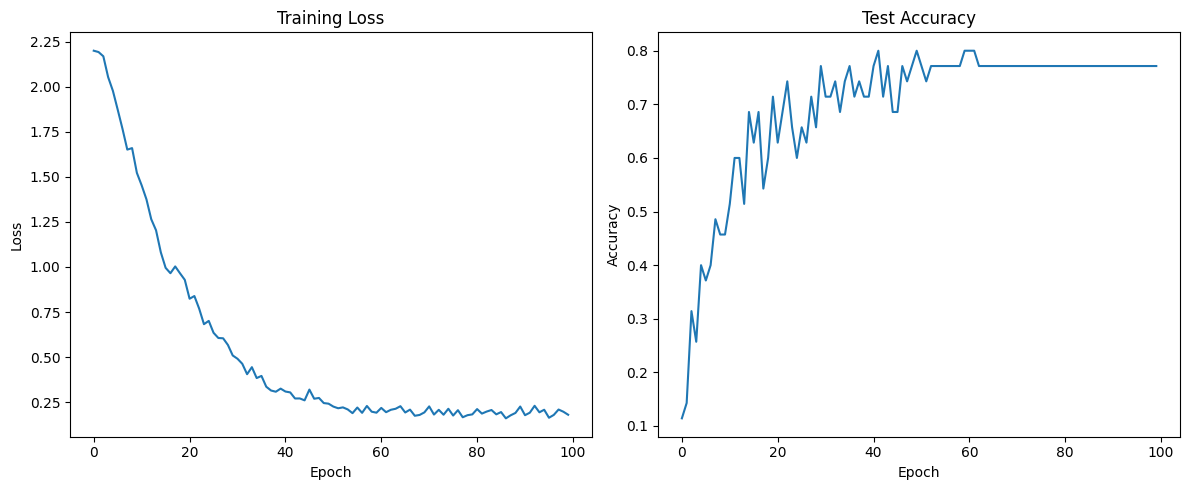

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [50]:
model.eval()
correct = 0
total = 0
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

print(f'Final Test Accuracy: {correct/total:.4f}')

Final Test Accuracy: 0.7714


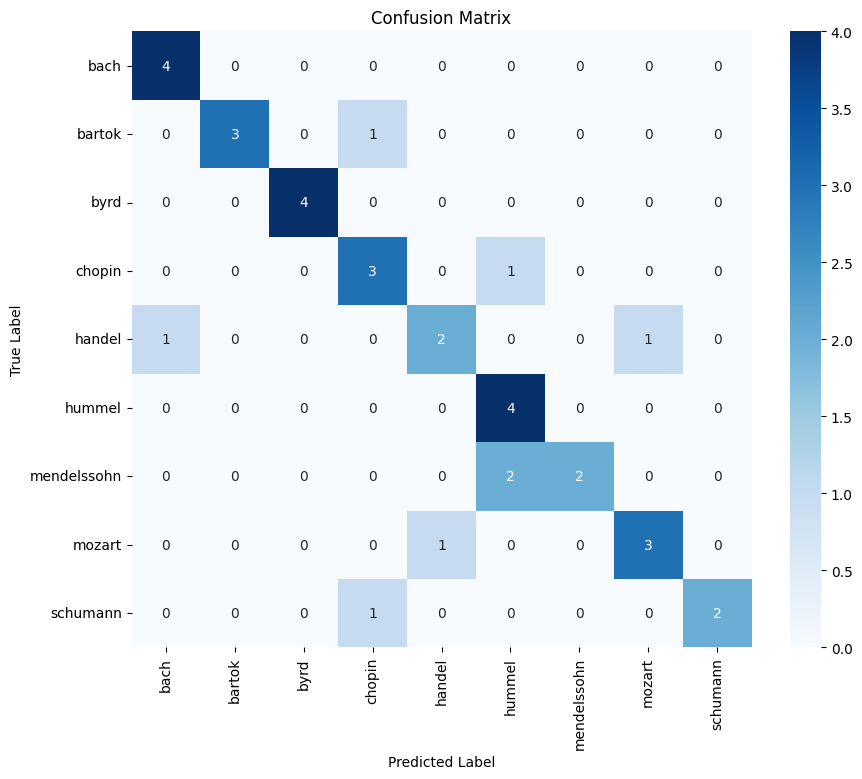

In [52]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()